# Feature Perspective Shift Experiment Pipeline

In [53]:
file_name = '../../data/25OCT/DCIM/VIDEO/241026_140824_077_FH.MP4'
every_n_frames = 3
output_file = './fps_data.csv'

FULL_RECORDINGS = True
RUN_EXAMPLES = False

### Import Libraries

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output, display

## Set up video

In [55]:
class VideoHandler:
    def __init__(self, video_path):
        self.video_path = video_path
        self.video = cv2.VideoCapture(video_path)
        self.fps = self.video.get(cv2.CAP_PROP_FPS)
        self.frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self.width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.current_frame = 0

    def get_frame(self):
        self.video.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
        ret, frame = self.video.read()
        if not ret:
            return None
        
        # mask bottom 100 pixels
        frame[-100:] = 0
        # mask outer 10% pixels on left and right
        frame[:, :int(self.width*0.1)] = 0
        frame[:, int(self.width*0.9):] = 0
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    def reset_video_to_start(self):
        self.current_frame = 0
    
    def get_frame_at(self, frame_number):
        self.current_frame = frame_number
        return self.get_frame()

    def get_next_frame(self, skip_every_n_frames = every_n_frames):
        self.current_frame += skip_every_n_frames
        return self.get_frame()
    
    def at_end_of_video(self, skip_every_n_frames = every_n_frames):
        return self.current_frame > (self.frame_count - skip_every_n_frames)

In [56]:
class videoPlayer:
    def __init__(self, video, evert_n_frames = every_n_frames, start = 0, end = None, output_file = output_file, record = False):
        self.video = video
        self.evert_n_frames = evert_n_frames
        self.current_frame = start
        self.output_file = output_file
        self.record = record
        self.recorder = None
        self.end = end if end is not None else self.video.frame_count  # Use total frames if `end` is not specified

    def play_frame(self, additional_images = [], overlays = []):
        frame = self.video.get_frame_at(self.current_frame)
        self.current_frame += self.evert_n_frames
        print(f'Frame: {self.current_frame}/{self.end}')
        
        for i in overlays:
            frame = cv2.addWeighted(frame, 1, i, 0.5, 0)

        for i in additional_images:
            # match image width to video frame width
            h = i.shape[0]
            w = frame.shape[1]
            i = cv2.resize(i, (w, int(h * w / i.shape[1])))
            frame = np.concatenate((frame, i), axis=0)

        # increase size of frame
        plt.imshow(frame)
        plt.axis('off')
        clear_output(wait=True)
        # increase size of video
        plt.gcf().set_size_inches(15, 15)
        display(plt.gcf())
        plt.close()

        if self.record:
            self.save_frame(frame)

    def save_frame(self, frame):
        if self.recorder is None:
            fps = self.video.fps / self.evert_n_frames
            self.recorder = cv2.VideoWriter(self.output_file, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame.shape[1], frame.shape[0]))
        self.recorder.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    def stop_recording(self):
        if self.recorder is not None:
            self.recorder.release()
            self.recorder = None

    def get_upcoming_frame(self):
        return self.video.get_frame_at(self.current_frame)
    
    def at_end_of_video(self):
        return self.current_frame > (self.end - self.evert_n_frames)

## Get and preprocess video

resolution: (1440, 2560, 3)


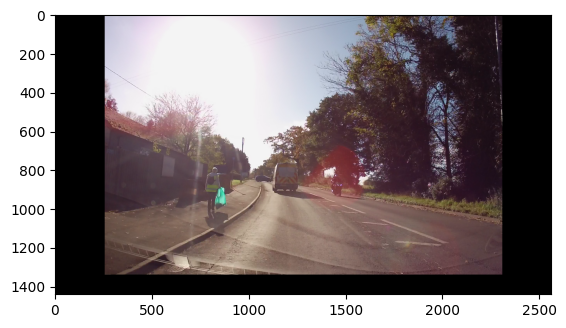

In [57]:
video = VideoHandler(file_name)
coloured_frame = video.get_frame()
print(f"resolution: {coloured_frame.shape}")

# output frame
plt.imshow(coloured_frame)

# VP detection: Global region 

Reduce resolution to 1080p for faster processing of global region

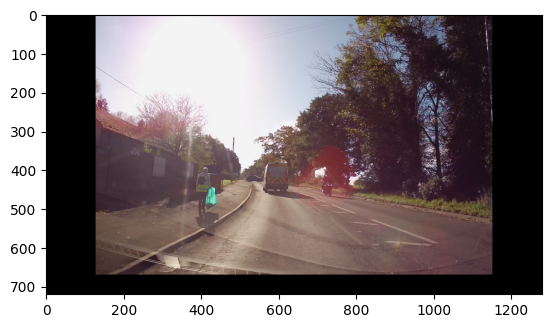

In [58]:
def reduce_frame_quality(frame):
    return cv2.resize(frame, (0,0), fx=0.5, fy=0.5)

reduced_quality_frame = reduce_frame_quality(coloured_frame)

plt.imshow(reduced_quality_frame)

Find SIFT features in global region for each frame

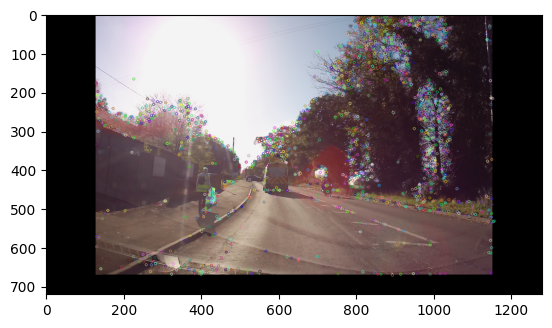

In [59]:
def get_features_from_sift(frame):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(frame, None)
    return keypoints, descriptors

def draw_keypoints(frame, keypoints):
    return cv2.drawKeypoints(frame, keypoints, None)

plt.imshow(draw_keypoints(reduced_quality_frame, get_features_from_sift(reduced_quality_frame)[0]))

### Matching between frames

Match between two frames

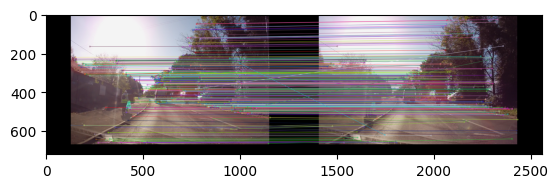

In [60]:
def match_features(descriptors1, descriptors2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append([m])
    return good_matches

def draw_matches(frame1, frame2, keypoints1, keypoints2, matches):
    return cv2.drawMatchesKnn(frame1, keypoints1, frame2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

frame1 = reduce_frame_quality(video.get_frame_at(0))
frame2 = reduce_frame_quality(video.get_frame_at(every_n_frames))

keypoints1, descriptors1 = get_features_from_sift(frame1)
keypoints2, descriptors2 = get_features_from_sift(frame2)

matches = match_features(descriptors1, descriptors2)

plt.imshow(draw_matches(frame1, frame2, keypoints1, keypoints2, matches))

### Process all frames

In [61]:
from multiprocessing.pool import ThreadPool as Pool

frame_features = [None]*int(video.frame_count//every_n_frames)

pool_size = 8

def worker(frame, frame_number):
    try:
        reduced_frame = reduce_frame_quality(frame)
        frame_features[frame_number] = get_features_from_sift(reduced_frame)
    except:
        print(f'Error with item at frame {frame_number}: {e}')

pool = Pool(pool_size)

print(f'processing fps:{int(video.fps // every_n_frames)}')
print(f'processing frames: {video.frame_count}')

video.reset_video_to_start()

frame_number = 0

frame = video.get_frame_at(0)

while(not video.at_end_of_video()):
    if frame is None:
        print(f"Error getting next frame")
        break
    pool.apply_async(worker, (frame, frame_number,))
    frame_number += 1
    frame = video.get_next_frame()


pool.close()
pool.join()

print(f"frame features: {len(frame_features)}")

processed_count = sum(1 for f in frame_features if f is not None)
print(f"processed frames: {processed_count}")

processing fps:9
processing frames: 1800
frame features: 600
processed frames: 600


### Matching between frames

In [19]:
frame_matched_features = []

for i in range(len(frame_features) - 1):
    matches = match_features(frame_features[i][1], frame_features[i+1][1])
    frame_matched_features.append(matches)

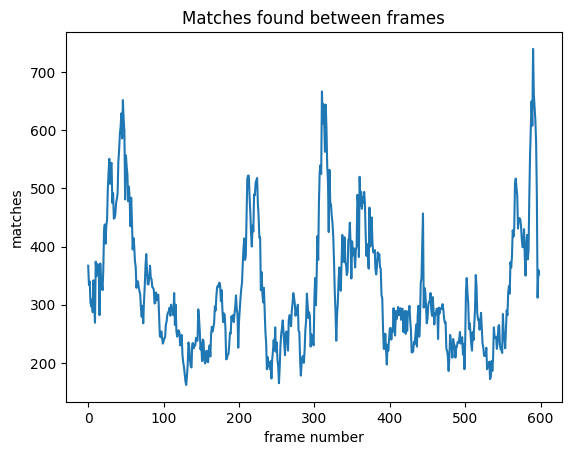

In [20]:
x = np.arange(len(frame_matched_features))
y = [len(matches) for matches in frame_matched_features]

plt.title('Matches found between frames')
plt.xlabel('frame number')
plt.ylabel('matches')
plt.plot(x, y)

### Plot and find likely VP by axis

In [21]:
def get_line_of_best_fit(x, y):
    return np.polyfit(x, y, 1)

In [22]:
frame_number = 1600

def plot_by_axis_difference_in_matches(frame_number, apply_cleaning = True, axis = 1, only_x_axis_crossing_point=False):
    matches = frame_matched_features[frame_number//every_n_frames]

    all_points = []
    final_points = []

    for match in matches:
        x1, y1 = frame_features[frame_number//every_n_frames][0][match[0].queryIdx].pt
        x2, y2 = frame_features[frame_number//every_n_frames+1][0][match[0].trainIdx].pt
        resulting_point = None
        if axis == 0:
            resulting_point = (y1,y2 - y1)
        else:
            resulting_point = (x1,x2 - x1)
        all_points.append(resulting_point)

    if apply_cleaning:
        final_points = [i for i in all_points if abs(i[1]) < 10 and abs(i[1]) > 0.5]

        if len(final_points) > 15:
            neigh = NearestNeighbors(n_neighbors=15)
            neigh.fit(final_points)
            distances, indices = neigh.kneighbors(final_points)

            for i in range(len(final_points)):
                if np.mean(distances[i]) < 2:
                    final_points[i] = None

            final_points = [i for i in final_points if i is not None]
    else:
        final_points = all_points


    x = [point[0] for point in final_points]
    y = [point[1] for point in final_points]

    m, b = get_line_of_best_fit(x, y)
    x_axis_crossing_point = -b / m

    if only_x_axis_crossing_point:
        return None, None, x_axis_crossing_point

    fig, ax = plt.subplots()
    ax.scatter(x, y)
    if axis == 0:
        ax.set_title('Difference in y between frames')
        ax.set_xlabel('y position on the frame')
        ax.set_ylabel('difference in y between frames (y2 - y1)')
    else:
        ax.set_title('Difference in x between frames')
        ax.set_ylabel('difference in x between frames (x2 - x1)')
        ax.set_xlabel('x position on the frame')

    ax.plot(x, m * np.array(x) + b, color='red')
    ax.axvline(x=x_axis_crossing_point, color='green')
    if axis == 0:
        ax.set_xlim(0, video.height // 2)
    else:
        ax.set_xlim(0, video.width // 2)
    fig.canvas.draw()
    graph_image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    width, height = fig.canvas.get_width_height()
    graph_image = graph_image.reshape((height, width, 4))
    rgb_image = graph_image[..., :3]


    plt.close()

    return rgb_image, final_points, x_axis_crossing_point

#### VP in the x axis

Number of points detected: 102
Average x shift: 2.068331849341299
X axis crossing point: 573.0814956011596


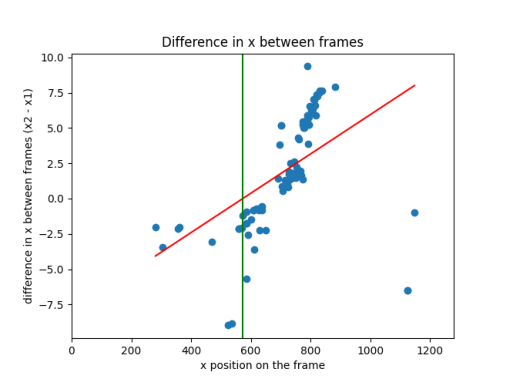

In [23]:
image, x_axis_shift_points, x_axis_crossing_point = plot_by_axis_difference_in_matches(frame_number, apply_cleaning = True, axis = 1)
plt.axis('off')
plt.imshow(image)
print(f'Number of points detected: {len(x_axis_shift_points)}')
print(f'Average x shift: {np.mean([point[1] for point in x_axis_shift_points])}')
print(f'X axis crossing point: {x_axis_crossing_point}')

#### VP in the y axis

Number of points detected: 97
Average y shift: -0.8644682894048002
Y axis crossing point: 440.06516040213234


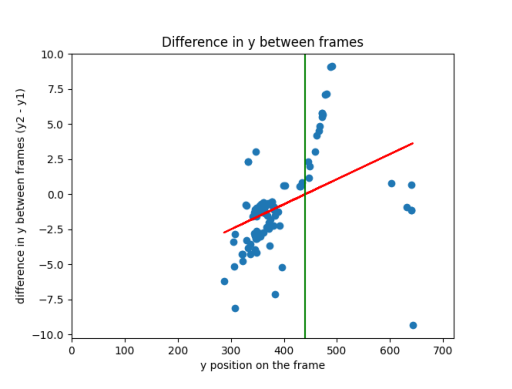

In [24]:
image, y_axis_shift_points, y_axis_crossing_point = plot_by_axis_difference_in_matches(frame_number, apply_cleaning = True, axis = 0)
plt.axis('off')
plt.imshow(image)
print(f'Number of points detected: {len(y_axis_shift_points)}')
print(f'Average y shift: {np.mean([point[1] for point in y_axis_shift_points])}')
print(f'Y axis crossing point: {y_axis_crossing_point}')

### Example of VP detection

In [25]:
show_graphs = True
examples_every_n_frames = 15

if FULL_RECORDINGS:
    video_player = videoPlayer(video, record=True, output_file='global_vp_graph_no_smoothing.avi')
else:
    video_player = videoPlayer(video, evert_n_frames=examples_every_n_frames, start=700, end=1000)
    
frame_h = video_player.get_upcoming_frame().shape[0]
frame_w = video_player.get_upcoming_frame().shape[1]

if not (FULL_RECORDINGS or RUN_EXAMPLES):
    print('No examples or full recordings have been flagged to run')

while(not video_player.at_end_of_video() and (RUN_EXAMPLES or FULL_RECORDINGS)):
    # x axis VP processing
    x_shift_image, x_axis_shift_points, x_axis_crossing_point = plot_by_axis_difference_in_matches(video_player.current_frame//every_n_frames, apply_cleaning=True, axis=1)
    x_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(x_vp_overlay, (int(x_axis_crossing_point*2), 0), (int(x_axis_crossing_point*2), frame_h), (0, 255, 0), 5)

    # y axis VP processing
    y_shift_image, y_axis_shift_points, y_axis_crossing_point = plot_by_axis_difference_in_matches(video_player.current_frame//every_n_frames, apply_cleaning=True, axis=0)
    y_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(y_vp_overlay, (0, int(y_axis_crossing_point*2)), (frame_w, int(y_axis_crossing_point*2)), (0, 255, 0), 5)

    # display frames
    additional_images = [x_shift_image, y_shift_image]
    overlays = [x_vp_overlay, y_vp_overlay]
    if not show_graphs:
        additional_images = []
    video_player.play_frame(additional_images, overlays)

    print(f'Number of points detected: {len(x_axis_shift_points)}')
    print(f'Average x shift: {np.mean([point[1] for point in x_axis_shift_points])}')
    print(f'X axis crossing point: {x_axis_crossing_point}')
    print(f'Average y shift: {np.mean([point[1] for point in y_axis_shift_points])}')
    print(f'Y axis crossing point: {y_axis_crossing_point}')


## Find global VP per frame

Text(0, 0.5, 'Distance')

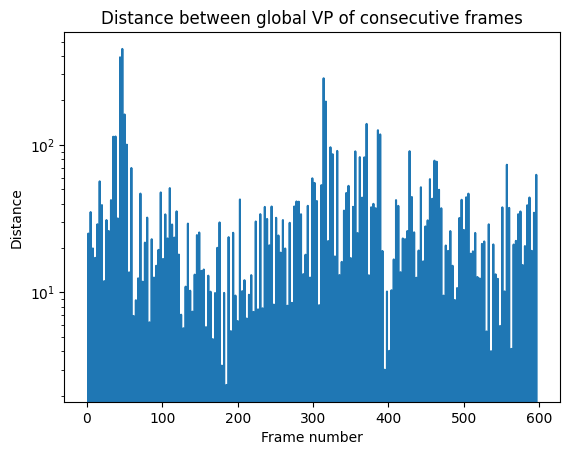

In [26]:
global_VP = []

def get_global_vp_for_frame(frame_number):
    _, _, x_axis_crossing_point = plot_by_axis_difference_in_matches(frame_number, apply_cleaning=True, axis=1, only_x_axis_crossing_point=True)
    _, _, y_axis_crossing_point = plot_by_axis_difference_in_matches(frame_number, apply_cleaning=True, axis=0, only_x_axis_crossing_point=True)

    return (x_axis_crossing_point, y_axis_crossing_point)

for i in range(0, video.frame_count//every_n_frames):
    global_VP.append(get_global_vp_for_frame(i))

global_VP = np.array(global_VP)

frame_distance = np.linalg.norm(global_VP[1:] - global_VP[:-1], axis=1)
plt.plot(frame_distance)
plt.title('Distance between global VP of consecutive frames')
plt.yscale('log')
plt.xlabel('Frame number')
plt.ylabel('Distance')

### Smooth the VP over time

Text(0, 0.5, 'Distance')

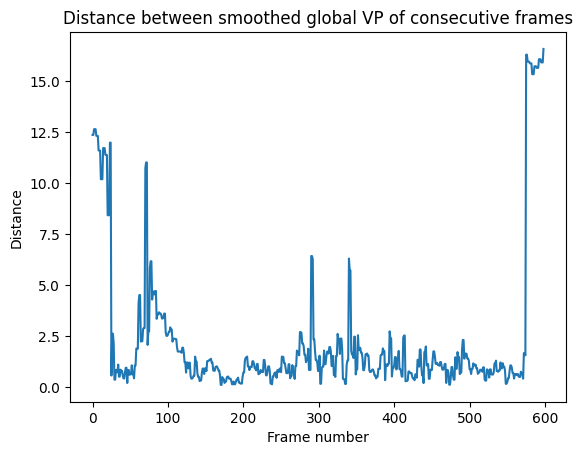

In [27]:
# smooth global VP vectors

def smooth_global_vp(global_VP, window_size=50):
    smoothed_global_VP = np.zeros_like(global_VP)
    for i in range(global_VP.shape[1]):
        smoothed_global_VP[:, i] = np.convolve(global_VP[:, i], np.ones(window_size)/window_size, mode='same')
    return smoothed_global_VP

smoothed_global_VP = smooth_global_vp(global_VP)

frame_distance = np.linalg.norm(smoothed_global_VP[1:] - smoothed_global_VP[:-1], axis=1)
plt.plot(frame_distance)
plt.title('Distance between smoothed global VP of consecutive frames')
plt.xlabel('Frame number')
plt.ylabel('Distance')

Add threshold before changing VP

Text(0, 0.5, 'Distance')

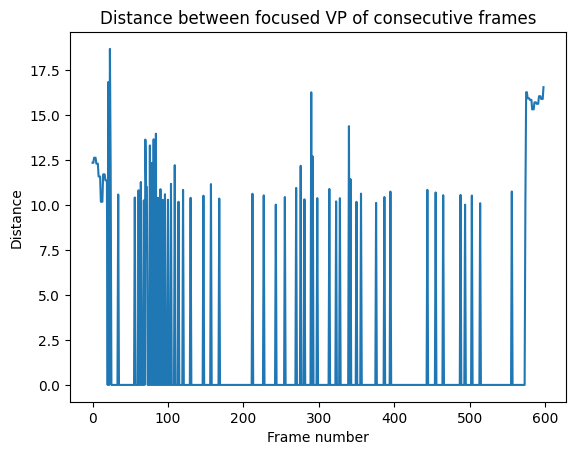

In [28]:
focused_vp = []

current_vp = smoothed_global_VP[0]

for i in range(0, len(smoothed_global_VP)):
    if np.linalg.norm(smoothed_global_VP[i] - current_vp) > 10:
        current_vp = smoothed_global_VP[i]
    focused_vp.append(current_vp)

smoothed_global_VP = np.array(focused_vp)

frame_distance = np.linalg.norm(smoothed_global_VP[1:] - smoothed_global_VP[:-1], axis=1)
plt.plot(frame_distance)
plt.title('Distance between focused VP of consecutive frames')
plt.xlabel('Frame number')
plt.ylabel('Distance')

#### Example of smoothed VP

In [29]:
if FULL_RECORDINGS:
    video_player = videoPlayer(video, record=True, output_file='global_vp_graph_with_smoothing.avi')
else:
    video_player = videoPlayer(video, evert_n_frames=15, start=400, end=1400)
    
frame_h = video_player.get_upcoming_frame().shape[0]
frame_w = video_player.get_upcoming_frame().shape[1]

if not (FULL_RECORDINGS or RUN_EXAMPLES):
    print('No examples or full recordings have been flagged to run')

while(not video_player.at_end_of_video() and (RUN_EXAMPLES or FULL_RECORDINGS)):
    # original vps
    current_vp = global_VP[video_player.current_frame//every_n_frames]
    x_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(x_vp_overlay, (int(current_vp[0]*2), 0), (int(current_vp[0]*2), frame_h), (0, 0, 255), 5)

    y_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(y_vp_overlay, (0, int(current_vp[1]*2)), (frame_w, int(current_vp[1]*2)), (0, 0, 255), 5)

    # smoothed vp
    current_smoothed_vp = smoothed_global_VP[video_player.current_frame//every_n_frames]
    x_smoothed_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(x_smoothed_vp_overlay, (int(current_smoothed_vp[0]*2), 0), (int(current_smoothed_vp[0]*2), frame_h), (0, 255, 0), 5)

    y_smoothed_vp_overlay = np.zeros((frame_h, frame_w, 3), dtype=np.uint8)
    cv2.line(y_smoothed_vp_overlay, (0, int(current_smoothed_vp[1]*2)), (frame_w, int(current_smoothed_vp[1]*2)), (0, 255, 0), 5)
    
    video_player.play_frame([], [x_vp_overlay, y_vp_overlay, x_smoothed_vp_overlay, y_smoothed_vp_overlay])

# VP detection: Local region
Using the global region VP, zoom in to the local region and find a more percise VP

In [30]:
# Clip around the global VP
def clip_frame_around_vp(frame, global_vp, clip_size=350):
    x_vp, y_vp = global_vp
    x_vp = int(x_vp * 2)
    y_vp = int(y_vp * 2)
    return frame[y_vp-clip_size:y_vp+clip_size, x_vp-clip_size:x_vp+clip_size] 

if FULL_RECORDINGS:
    video_player = videoPlayer(video, record=True, output_file='clipped_frame_around_vp.avi')
else:
    video_player = videoPlayer(video, evert_n_frames=10, start=500, end=1400)

frame_h = video_player.get_upcoming_frame().shape[0]
frame_w = video_player.get_upcoming_frame().shape[1]

if not (FULL_RECORDINGS or RUN_EXAMPLES):
    print('No examples or full recordings have been flagged to run')

while(not video_player.at_end_of_video() and (RUN_EXAMPLES or FULL_RECORDINGS)):
    # only move the focused vp if the current vp is more than 50 pixels away
    current_vp = global_VP[video_player.current_frame//every_n_frames]
    print(f'Smoothed VP: {smoothed_global_VP[video_player.current_frame//every_n_frames]}')
    print(f'Current VP: {current_vp}')
    frame = video_player.get_upcoming_frame()
    clipped_frame = clip_frame_around_vp(frame, smoothed_global_VP[video_player.current_frame//every_n_frames])

    video_player.play_frame(additional_images=[clipped_frame])

# Analysis

View the results at frame level

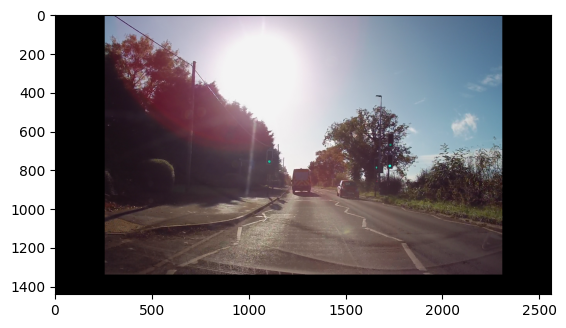

In [31]:
frame_number = 200
matches_at_frame = frame_matched_features[frame_number // every_n_frames]
frame = video.get_frame_at(frame_number)

plt.imshow(frame)

# Output Results
Video recordings of the results are saves when FULL_RECORDING is set to True

We wish to collect the results of the experiment in a csv files

## Interpolate results for all frames

In [34]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_vectors(results, frame_count):
    x = np.arange(len(results))
    interpolated_results = np.zeros((frame_count, results.shape[1]))

    for i in range(results.shape[1]):
        y = results[:, i]
        f = interp1d(x, y, kind='cubic')
        x_new = np.linspace(0, len(results) - 1, frame_count)
        interpolated_results[:, i] = f(x_new)
        
    return interpolated_results

In [41]:
smoothed_global_VP_interpolated = interpolate_vectors(smoothed_global_VP, video.frame_count)
print(f'smooth_global_vp at len {len(smoothed_global_VP_interpolated)} matches video frame length {video.frame_count}')

smooth_global_vp at len 1800 matches video frame length 1800


In [43]:
output_file = 'smoothed_global_vp.csv'
df = pd.DataFrame(smoothed_global_VP_interpolated, columns=['x', 'y'])
df.to_csv(output_file, index=False)